### Per poter scaricare il dataset dobbiamo partire con questo comando
## !pip install kaggle --upgrade

In [1]:
!cp kaggle.json ~/.kaggle/

In [2]:
# Facciamo il login tramite token su Kaggle dopo aver scaricato le API ed aver messo il file "kaggle.json" nel giusto percorso ( su windows "C:\\Users\\{nomeutente}\\.kaggle\\")

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [3]:
# scarichiamo il dataset

!kaggle competitions download -c dogs-vs-cats

dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
# Import

import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



In [5]:
# print(tf.__version__)

In [6]:
# Spacchettiamo  il dataset dallo zip

main = "dogs-vs-cats.zip"
train = "train.zip"
test = "test1.zip"
cartella_principale = "DOGvsCATS/"
files = "dataset/"

import zipfile

if os.path.isfile(train) and os.path.isfile(test) == True:
    pass
else:
    with zipfile.ZipFile(main,"r") as zipp:
        zipp.extractall()
    if os.path.isdir("train") and os.path.isdir("test1") == True:
        pass
    else:
        with zipfile.ZipFile(train, "r") as zipp:
            zipp.extractall(files)

        with zipfile.ZipFile(test, "r") as zipp:
            zipp.extractall(files)

In [7]:
# Creiamo un dataframe per poter modellare i dati

dataset_train_path = "dataset/train/"

nomefile = os.listdir(dataset_train_path)
specie = [x.split(".")[0] for x in nomefile]

dati = pd.DataFrame({"Nome_File": nomefile, "Specie":specie})

#dati["Specie"] = dati["Specie"].replace(["cat","dog"],[0,1])


dati

,Nome_File,Specie
0,cat.10138.jpg,cat
1,dog.11215.jpg,dog
2,cat.10033.jpg,cat
3,dog.6849.jpg,dog
4,dog.10002.jpg,dog
...,...,...
24995,dog.2200.jpg,dog
24996,dog.1938.jpg,dog
24997,cat.1365.jpg,cat
24998,dog.11565.jpg,dog


In [8]:
# main = "dogs-vs-cats.zip"
# train = "train.zip"
# test = "test1.zip"
# cartella_principale = "DOGvsCATS/"
# files = "working/"

# train_path = "working/train"
# test_path = "working/test"

train_path = "working/train/"
test_path = "working/test/"

# Separiamo le immagini per cani e gatti
from os import makedirs, listdir
from random import random
from shutil import copyfile

cartel= [train_path, test_path]
# Creazione sottocartelle
for i in cartel:
    nome_cartel=["/cani/","/gatti/"]
    for j in nome_cartel:
        nuova_cartel = i+j
        makedirs(nuova_cartel, exist_ok=True)

# Percentuale di immagini per validare il training
valutazione = 0.2

# Copia delle immagini nelle sottocartelle
src_dir = "dataset/"
source = "dataset/train/"
for immagine in listdir(source):
    src=src_dir+"train/"+immagine
    destinazione="working/train/"
    if random()< valutazione:
        destinazione="working/test/"
    if immagine.startswith("cat"):
        dest = destinazione + "gatti/" + immagine
        copyfile(src, dest)
    elif immagine.startswith("dog"):
        dest = destinazione + "cani/" + immagine
        copyfile(src, dest)


path1 = "working/train/gatti"
path2= "working/train/cani"
path3= "working/test/gatti"
path4= "working/test/cani"

print('Ci sono ' ,len(os.listdir(path1)),' immagini di gatti in training')
print('Ci sono ' ,len(os.listdir(path2)),' immagini di cani in training')
print('Ci sono ' ,len(os.listdir(path3)),' immagini di gatti in test')
print('Ci sono ' ,len(os.listdir(path4)),' immagini di cani in test')

Ci sono  11973  immagini di gatti in training
Ci sono  11973  immagini di cani in training
Ci sono  4489  immagini di gatti in test
Ci sono  4462  immagini di cani in test


In [9]:
# Settiamo i parametri
grandezza_immagine = 256
grandezza_batch = 32

# Creiamo i generatori

train_gen = keras.utils.image_dataset_from_directory(
    directory= "working/train",
    labels="inferred",
    label_mode="binary",
    batch_size=grandezza_batch,
    image_size=(grandezza_immagine,grandezza_immagine)
)

test_gen = keras.utils.image_dataset_from_directory(
    directory= "working/test",
    labels="inferred",
    label_mode="binary",
    batch_size=grandezza_batch,
    image_size=(grandezza_immagine,grandezza_immagine)
)

Found 23946 files belonging to 2 classes.
Found 8951 files belonging to 2 classes.


In [10]:
# Creiamo il modello sequenziale
modello = keras.Sequential()
modello.add(layers.Conv2D(32, (3,3), input_shape=(grandezza_immagine,grandezza_immagine,3), activation="relu"))
modello.add(layers.BatchNormalization())
modello.add(layers.MaxPooling2D((2,2)))
modello.add(layers.Conv2D(64,(3,3),activation="relu"))
modello.add(layers.BatchNormalization())
modello.add(layers.MaxPooling2D((2,2)))
modello.add(layers.Conv2D(128,(3,3),activation="relu"))
modello.add(layers.BatchNormalization())
modello.add(layers.MaxPooling2D((2,2)))

modello.add(layers.Flatten())
modello.add(layers.Dense(512, activation="relu"))
modello.add(layers.Dropout(0.2))
modello.add(layers.Dense(1, activation="sigmoid"))

# Compiliamo il modello
modello.compile(optimizer = "adam", loss="binary_crossentropy", metrics=["accuracy"])

modello.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                        

In [11]:
# Addestriamo il modello
history = modello.fit(train_gen, epochs = 10, validation_data=test_gen)

Epoch 1/10
749/749 [==============================] - 116s 137ms/step - loss: 1.3335 - accuracy: 0.6737 - val_loss: 0.7361 - val_accuracy: 0.6918
Epoch 2/10
749/749 [==============================] - 90s 120ms/step - loss: 0.4943 - accuracy: 0.7524 - val_loss: 0.4381 - val_accuracy: 0.7829
Epoch 3/10
749/749 [==============================] - 86s 115ms/step - loss: 0.5048 - accuracy: 0.7739 - val_loss: 2.1872 - val_accuracy: 0.7166
Epoch 4/10
749/749 [==============================] - 88s 117ms/step - loss: 0.4071 - accuracy: 0.8052 - val_loss: 0.5033 - val_accuracy: 0.7776
Epoch 5/10
749/749 [==============================] - 85s 114ms/step - loss: 0.3523 - accuracy: 0.8343 - val_loss: 0.4078 - val_accuracy: 0.8240
Epoch 6/10
749/749 [==============================] - 94s 125ms/step - loss: 0.2956 - accuracy: 0.8614 - val_loss: 0.2715 - val_accuracy: 0.8767
Epoch 7/10
749/749 [==============================] - 86s 115ms/step - loss: 0.2515 - accuracy: 0.8810 - val_loss: 0.3984 - val_a

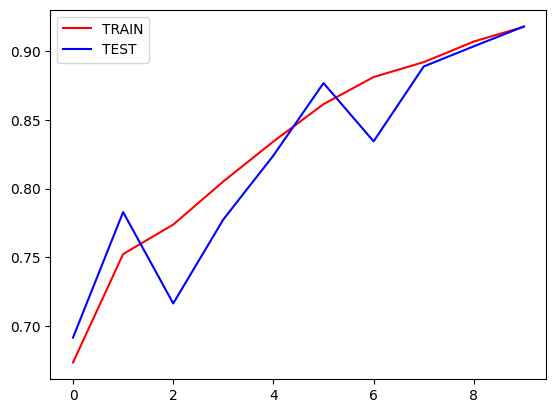

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], color="red", label="TRAIN")
plt.plot(history.history["val_accuracy"], color="blue", label="TEST")
plt.legend()
plt.show()

In [15]:
import cv2

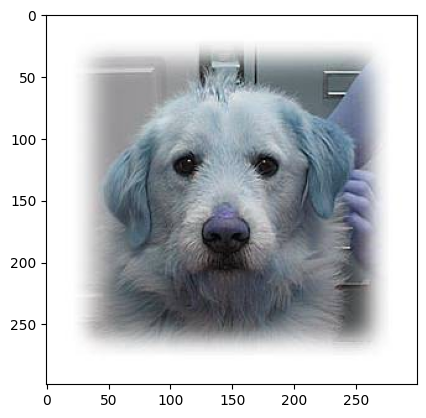

In [38]:
test_immagine = cv2.imread("dataset/test1/3.jpg")
plt.imshow(test_immagine)

In [39]:
test_immagine.shape

(299, 300, 3)

In [42]:
test_immagine = cv2.resize(test_immagine,(256,256))
input = test_immagine.reshape((1,256,256,3))

In [43]:
predizione = modello.predict(input)
if predizione > 0.5 :
  print("Gatto")
elif predizione <0.5:
  print("Cane")

1/1 [==============================] - 0s 25ms/step
Cane
